After watching Arjan's video on "Requests vs HTTPX vs Aiohttp | Which One to Pick?" [https://www.youtube.com/watch?v=OPyoXx0yA0I], added to the fact that currently in my work I need to develop small tools or scripts to automate tasks and extract data in Kubernetes clusters, I decided to compare HTTP libraries and Kubernetes clients in Python, to identify which one has the shortest response times.

The objective of this analysis is to measure the performance of each library and/or client in terms of response times in handling network IO. From the initiation of the HTTP request, through a method provided by the tested library, to the reception of the required data or library/client object. Aspects such as data structure manipulation in the response, testing concurrency levels supported by each library/client, ease of use and simplicity, among other features, are not covered in what is explained below.

Why Python? 

Although Go is the de facto standard for Kubernetes and its ecosystem, Python is a viable alternative due to its widespread usage, fast learning curve, and versatility in creating tools rapidly. Additionally, the design, structure, and HTTP interface of the (Kubernetes API)[https://kubernetes.io/docs/concepts/overview/kubernetes-api/] allows you to quickly start exploring and manipulating its resources via the HTTP methods.

By simply running `kubectl get --raw /`, we can retrieve the list of available resource URIs in a cluster, and coupled with the use of standard HTTP methods to operate on the resources, the manipulation of the cluster resources is a well-known task. It's possible to use `curl` or any client library from go, python, ruby, etc.

For these reasons, I gathered some of the best-known available HTTP clients and Kubernetes clients in Python's. Looking at the available HTTP clients, I selected the Requests, HTTPX and aiohttp libraries. Also, for the Python Kubernetes clients, I chose the official client, lightkube, pykube-ng, and kr8s.

I added asynchronous tests with help of the [asyncio](https://docs.python.org/3/library/asyncio.html) library for a few reasons: its increasingly widespread usage, its growing implementation in various Kubernetes clients, and out of curiosity to verify if, for these IO time-focused tests, concurrency usage produces substantial changes.

Furthermore, I wanted to check if leveraging asyncio features contributes to improving response times. And indeed, using methods that execute tasks concurrently reduces response time, especially for any requests that can be initiated simultaneously. These features come with a cost, as implementing concurrency also requires extra care and attention that we might not take with synchronous code.

From an infrastructure perspective, three types of clusters were used, all in version 1.28 with similar computing capabilities but with different deployments. The first is a locally deployed Minikube cluster, the second is an EKS-managed cluster deployed on AWS, and the third is an upstream Kubernetes solution (vanilla Kubernetes) deployed on EC2 instances in AWS.

Summarizing the characteristics of the tested platforms:

 - Minikube: 1 control plane node, 3 worker nodes, CNI Calico, Podman driver. Default hardware resources (2 CPU cores, 2048 GB RAM)
   - Template: `minikube start -p k8s -n 4 --network-plugin=cni --cni=calico --kubernetes-version=1.28.0 --driver=podman`

  - Vanilla: 2 control plane t3.small, 2 worker nodes t3.micro, deployed in the us-east-1 region
   - Template: [kube-the-hard-way-aws](https://github.com/mauriciomem/kube-the-hard-way-aws)

  - EKS: Managed control plane, 1 node group with t3.micro instances, deployed in the us-east-1 region
    - Template: [eksctl demo cluster](./eksctl-demo-cluster.yml)

Regarding the code details of each library/client, the response time measurement included:

 - Initialization of the HTTP library class and the Kubernetes client.
 - Read and write requests, from invocation to response, in the format handled by each library/client.

Each test scenario consisted of 50 iterations of each library/client to each endpoint, at three different moments during the day (morning, afternoon, and night), totaling 450 iterations per library/client.

Each iteration included: 4 read requests (namespaced and non-namespaced resources) and 2 write requests, specifically creating and deleting a namespace.

The list of clients used was as follows:


HTTP client/server libraries in Python

|    http client test     | Description                                             | Library official reference |
|-------------------------|---------------------------------------------------------|---------------------------------------------------------|
|   [req_sync_nosess]()       | Requests sync HTTP client, no session object | [Requests](https://requests.readthedocs.io/en/latest/) |
|   [req_sync_sess]()         | Requests sync HTTP client, with session object| [Requests session objects](https://requests.readthedocs.io/en/latest/user/advanced/#session-objects) |
|   [aiohttp_async_c]()       | aiohttp asynchronous HTTP client with "concurrent" executions  | [aiohttp](https://docs.aiohttp.org/en/stable/)|
|   [aiohttp_async]()         | aiohttp asynchronous HTTP client with "sequencial" executions | [aiohttp](https://docs.aiohttp.org/en/stable/) |
|   [httpx_async_c]()         | HTTPX async HTTP client with "concurrent" executions| [httpx](https://www.python-httpx.org/) |
|   [httpx_async]()           | HTTPX async HTTP client with "sequencial" executions| [httpx](https://www.python-httpx.org/) |

Kubernetes client libraries in Python

|   kubernetes client test   | Description                                             | Client official reference |
|----------------------------|---------------------------------------------------------|---------------------------------------------------------|
|   [kr8s_async]()       | kr8s client library for Kubernetes, async API| [kr8s.asyncio](https://docs.kr8s.org/en/latest/asyncio.html) |
|   [kr8s_sync]()        | kr8s client library for Kubernetes, sync API| [kr8s](https://github.com/kr8s-org/kr8s) |
|   [k8s_sync]()         | Oficial kubernetes library, only supports a sync API| [kubernetes-client](https://github.com/kubernetes-client/python) |
|   [k8s_async]()        | Async library based on the oficial Kubernetes library | [kubernetes_asyncio](https://github.com/tomplus/kubernetes_asyncio)  |
|   [lightkube_async]()  | Test lightkube kubernetes client in async mode | [lightkube](https://lightkube.readthedocs.io/en/latest/async-usage/) |
|   [lightkube_sync]()   | Test lightkube kubernetes client in sync mode  | [lightkube](https://lightkube.readthedocs.io/en/latest/) |
|   [pykube-ng_async]()  | A lightweight kubernetes client library, tuned to support async/await features | [pykube-ng](https://codeberg.org/hjacobs/pykube-ng) |
|   [pykube-ng_sync]()   | A lightweight Kubernetes client library, straightforward use in sync mode | [pykube-ng](https://codeberg.org/hjacobs/pykube-ng) |


Considerations about HTTP libraries and Kubernetes clients

aiohttp

I avoided installing the [aiodns library](https://pypi.org/project/aiodns/) to ensure that the rest of the clients were under the same testing conditions. However, measuring the potential difference in response times that aiodns may represent is still pending.

I performed two test scenarios:

 - `aiohttp_async` executes all tasks on read operations concurrently with `asyncio.gather()` and then executes write tasks sequentially, all within the aiohttp.ClientSession() context.
 - `aiohttp_async_c` includes a wrapper async function to run all reading and writing tasks concurrently, with the extra care to ensure the write tasks are run one after another. Again, this process is run inside the context of `aiohttp.ClientSession()`

HTTPX

With HTTPX, I only tested its async API, replicating an approach identical to the aiohttp test scenarios.

Requests

With the Requests library, I wanted to confirm what Arjan mentioned in his video, considering Kubernetes endpoints specifically. Each Requests scenario differs in whether the `requests.Session()` is invoked or not.

Kubernetes clients

Comparing all Kubernetes clients, the first evidence that stands out from the graphs is the clear difference in response time between the vanilla/upstream Kubernetes and EKS. Could these results arise as a consequence of how EKS scales its control plane depending on its load, concurrency, and overall cluster usage? Does it affect the authentication workflow to the EKS endpoint? Or does the abstraction layer by each client logic add a special overhead to this endpoint? These questions weren't answered by this analysis.

Keep in mind that Kubernetes clients present a considerable difference in the ease of use and development speed with the Kubernetes API, involving just a few lines of code to have a running solution for your daily tasks in Kubernetes.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
source = './data/kubeapitest.csv'
data = pd.read_csv(source, encoding='utf-8')

In [3]:
data = data.rename(columns={'test':'client'})
data = data.replace('https://192.168.49.2:8443', 'minikube')
data = data.replace('https://ECCD60717C5B6EB3DC2CD846F337E610.gr7.us-east-1.eks.amazonaws.com', 'EKS')
data = data.replace('https://E3832ACBD6BB94E3F4B9907A49FCC899.gr7.us-east-1.eks.amazonaws.com', 'EKS')
data = data.replace('https://ec2-34-203-229-20.compute-1.amazonaws.com:6443', 'vanilla')
data.sample(20)

,client,endpoint,time,hour,iteration,round
3628,httpx_async_c,EKS,0.4930,19,29,2
6200,req_sync_nosess,minikube,0.0854,22,1,3
1167,lightkube_sync,EKS,0.8083,0,18,1
5017,httpx_async_c,EKS,0.6007,22,18,3
1582,httpx_async,vanilla,0.6724,9,33,1
5096,httpx_async,EKS,0.7541,22,47,3
1910,pykube-ng_async,vanilla,0.4777,9,11,1
3364,pykube-ng_sync,vanilla,0.5423,18,15,2
3688,httpx_async,EKS,0.6817,19,39,2
3366,pykube-ng_sync,vanilla,0.4685,18,17,2


In [4]:
round1 = data['round'] == 1
round2 = data['round'] == 2
round3 = data['round'] == 3

data['total_iterations'] = data.loc[round1, 'iteration'] + 0
data.loc[round2, 'total_iterations'] = data.loc[round2, 'iteration'] + 50
data.loc[round3, 'total_iterations'] = data.loc[round3, 'iteration'] + 100

In [5]:
vanilla = data['endpoint'] == 'vanilla'
eks = data['endpoint'] == 'EKS'
cloud = data.loc[vanilla | eks, :]

In [6]:
client = data['client'] == 'aiohttp_async'
server = data['endpoint'] == 'minikube'

data[client & server].count()

client              150
endpoint            150
time                150
hour                150
iteration           150
round               150
total_iterations    150
dtype: int64

In [7]:
sns.set_style("darkgrid", {"grid.color": "1"})
sns.set_palette("husl", 1)

The first graph shows the average response times per client with respect to each endpoint. The idea of including tests with local clusters running on Minikube is to identify whether clients show a correlation in response times across all tested endpoints.

For the tested HTTP clients, HTTPX, Requests, and aiohttp maintained their trend of response times on each of the endpoints, where `aiohttp_async_c` emerged with the best average results on each endpoint, and `req_sync_nosess` being the worst result on all endpoints.

Regarding Kubernetes clients, surprisingly, the `lightkube_sync` test dethroned its asynchronous alternative. In these tests, there was no clear winner between asynchronous and synchronous options, and, in fact, the performance of the former was worse, especially for local tests on Minikube, where network IO becomes less relevant. What is evident is that response times on the endpoint presenting the upstream version of Kubernetes were clearly lower than those of the EKS cluster. It will remain to identify the characteristics of the EKS control plane managed by AWS directly. According to the test conditions, it seems that the [t3 instances](https://aws.amazon.com/ec2/instance-types/t3/) that make up the control plane and the load balancer are sufficient to surpass the performance of the EKS cluster (in this scenario, concurrency tests would be ideal to compare how performance is sustained over time).

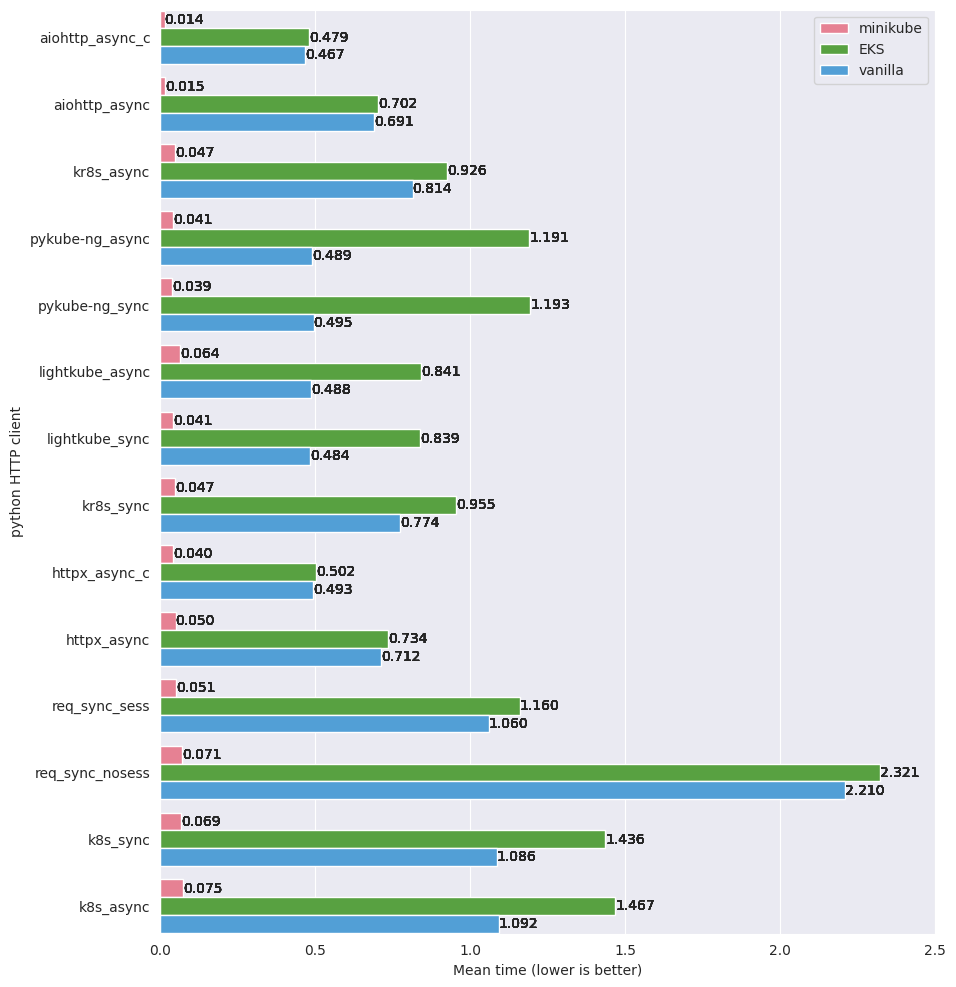

In [8]:
ax = sns.barplot(data=data.sort_values(by=['time'], ascending=True), 
                 x="time", 
                 y="client", 
                 errorbar=None, 
                 hue='endpoint')
ax.figure.set_size_inches(10,12)

for c in ax.containers:
    for v in c:
        labels = [f'{(v.get_width()):.3f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')

ax.legend(loc="upper right", frameon=True)
ax.set(xlim=(0, 2.5), 
       ylabel="python HTTP client",
       xlabel="Mean time (lower is better)")
ax.autoscale_view()
ax.margins(y=0.001)


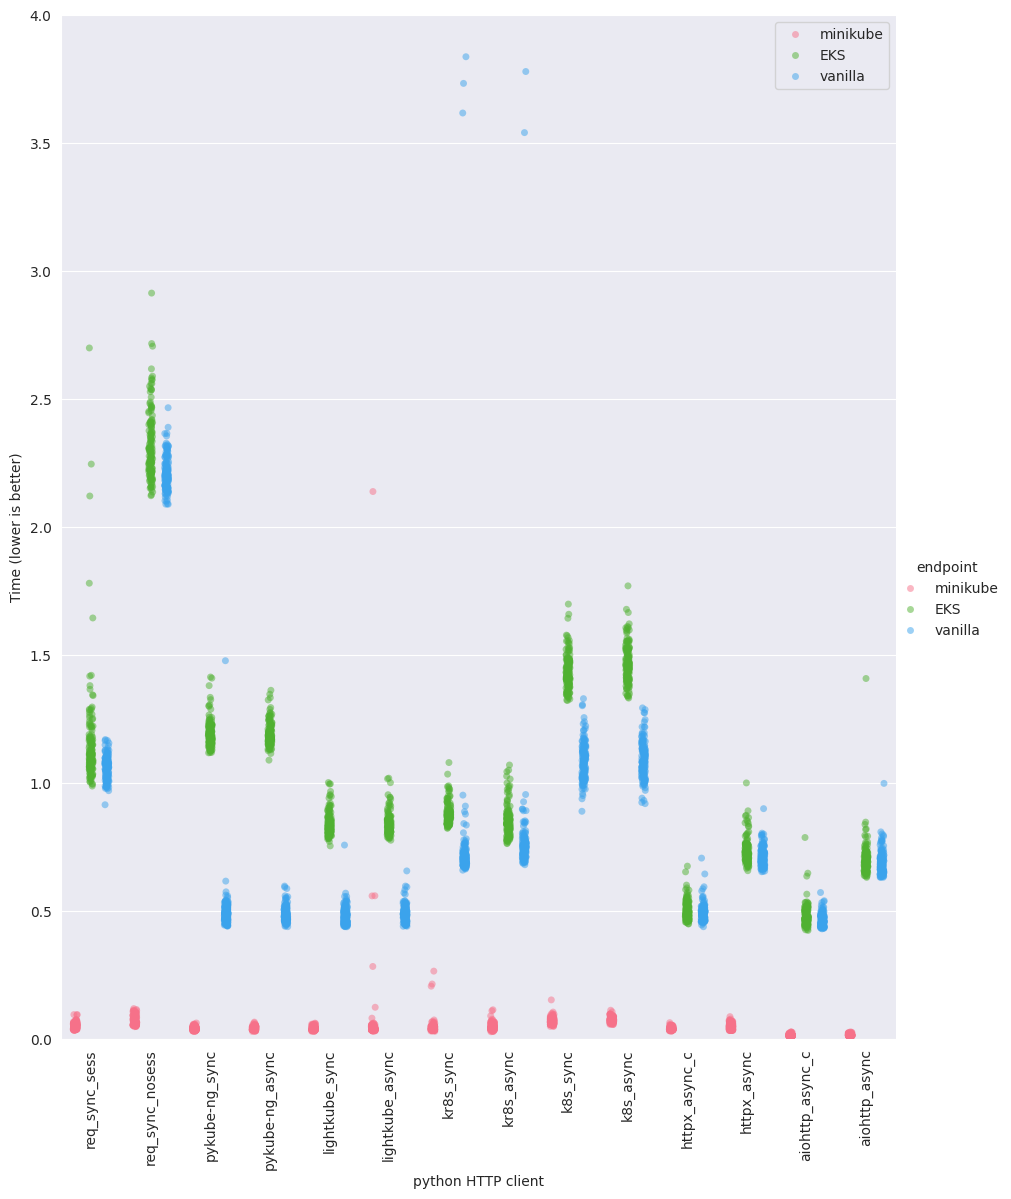

In [9]:
g = sns.catplot(data.sort_values(by=['client'], ascending=False), 
                legend=True, x='client', y='time', 
                kind='strip', 
                dodge=True, 
                hue='endpoint', 
                alpha=.5, 
                aspect=2)
g.set_xticklabels(rotation=90)
g.figure.set_size_inches(10,12)
g.set(ylim=(0,4), xlabel='python HTTP client', 
      ylabel='Time (lower is better)')

ax = g.ax

ax.legend(loc='upper right', frameon=True)

plt.show()

From another perspective focused on the EKS and vanilla Kubernetes endpoints, to help identify the dispersion of the results shown in the previous graph, the histogram helps us identify that the majority of requests to the vanilla/upstream endpoint resulted in reduced response times compared to the EKS endpoint.

[(0.0, 3.5),
 Text(0, 0.5, 'Total iterations per endpoint'),
 Text(0.5, 0, 'Time (in sec)')]

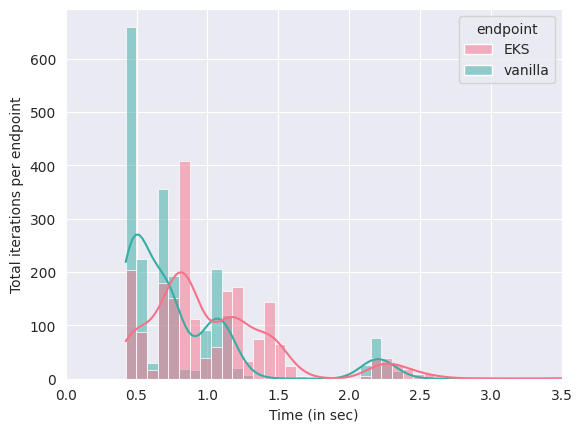

In [10]:
cloud = data[data['endpoint'].isin(['vanilla', 'EKS'])]
g = sns.histplot(data=cloud, x="time", hue="endpoint", kde=True, legend=True)
g.set(xlim=(0, 3.5), 
       ylabel="Total iterations per endpoint",
       xlabel="Time (in sec)")

If we compare all iterations across all evaluated clients and group them according to endpoints, performance remains constant as iterations progress. There are no significant dispersions between each client's evaluated response time.

It can be identified that at the beginning of each iteration round, there is a sharp increase in response times, probably required by the establishment of the network connection and all the steps this involves, from packet routing through the creation of the TCP connection, name resolution of the endpoints to the TLS negotiation and authentication process, and the transmission of the payload between the client and server ends.
Later on, we can review if there is any particular client or clients that cause the distortion at the start of the round.

Finally, at the beginning of the first round, in the morning, a small increase in response times is observed between iteration 20 and 40.

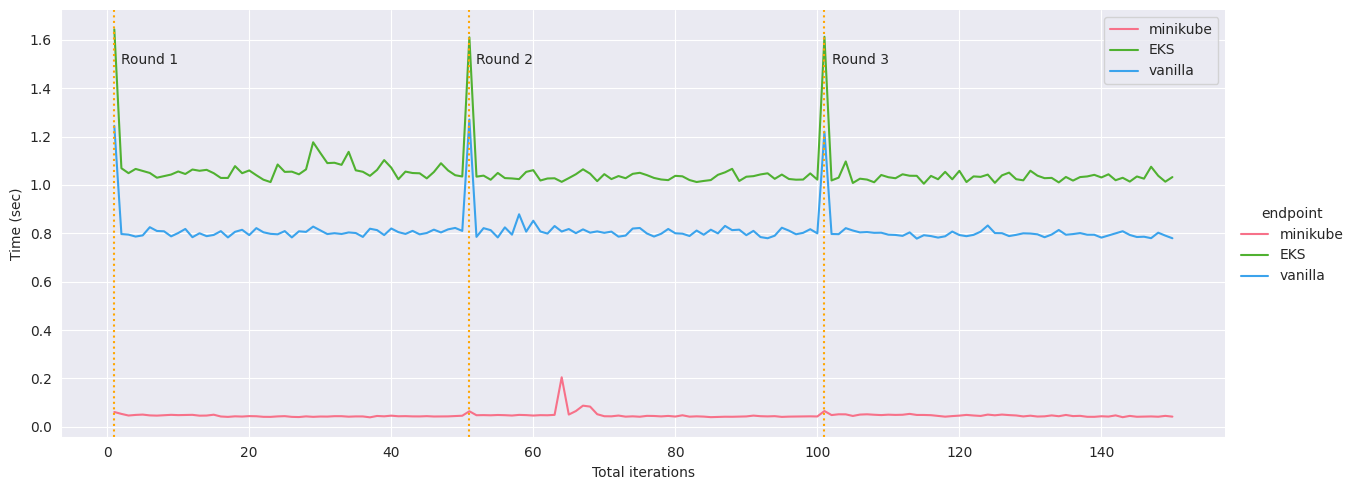

In [11]:
g = sns.relplot(data=data, kind="line", y='time', x='total_iterations', hue='endpoint', errorbar=None, aspect=2.5)

g.ax.axvline(x=1, color='orange', linestyle=':')
g.ax.axvline(x=51, color='orange', linestyle=':')
g.ax.axvline(x=101, color='orange', linestyle=':')

g.ax.text(x=2, y=1.5, s="Round 1")
g.ax.text(x=52, y=1.5, s="Round 2")
g.ax.text(x=102, y=1.5, s="Round 3")

g.set_axis_labels("Total iterations", "Time (sec)")

plt.legend()

In [12]:
# aiohttp_async = data[data['client'] == 'aiohttp_async']
# aiohttp_async_r3 = aiohttp_async.loc[round3, :]
# g = sns.relplot(data=aiohttp_async_r3, kind="line", y='time', x='iteration', hue='endpoint', aspect=2.5)

Breaking down the previous graph by HTTP clients only, the difference in response times during all iterations between the EKS and vanilla endpoints is not clearly identifiable. Only the Requests library had special difficulties in maintaining response times similar to the upcoming rounds, especially the test that does not instantiate a session object, causing each HTTP method used by the library to involve a longer connection establishment process.

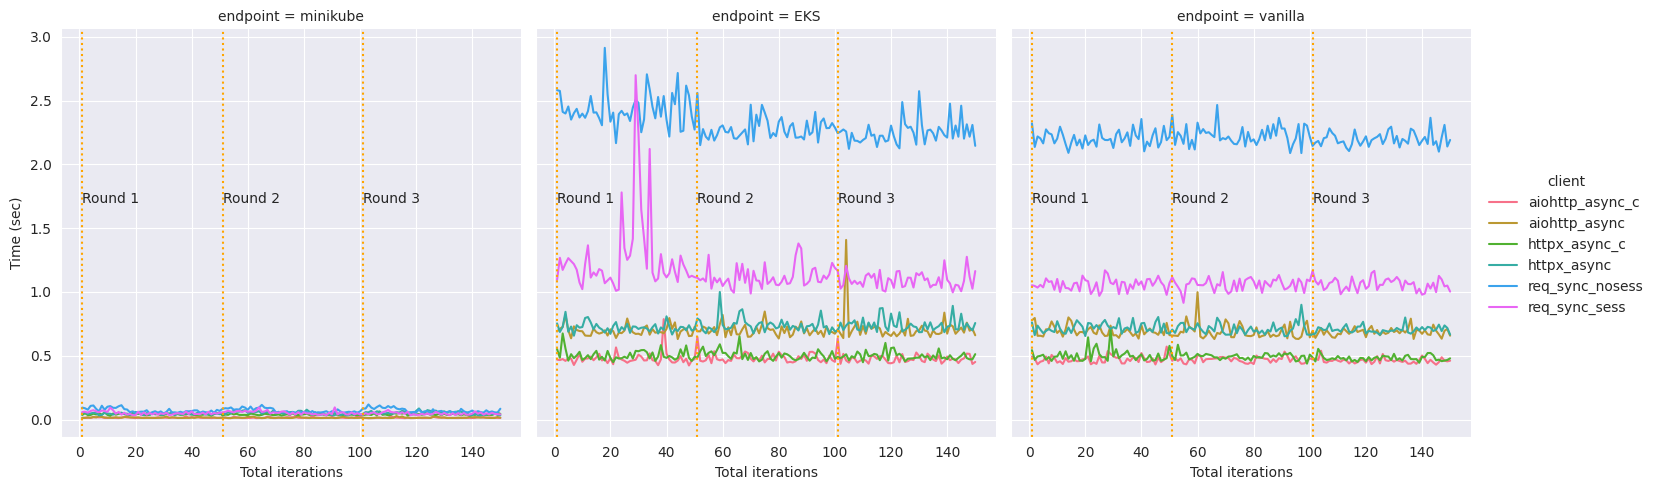

In [13]:
http_clients = data[data['client'].str.startswith(('aiohttp', 'httpx', 'req'))]
g = sns.relplot(data=http_clients, kind="line", y='time', x='total_iterations', 
                col='endpoint', 
                hue='client', 
                errorbar=None, 
                aspect=1,
                )
g.set_axis_labels("Total iterations", "Time (sec)")

for ax in g.axes.ravel():
    ax.axvline(x=1, color='orange', linestyle=':')
    ax.axvline(x=51, color='orange', linestyle=':')
    ax.axvline(x=101, color='orange', linestyle=':')
    ax.text(x=1, y=1.7, s="Round 1")
    ax.text(x=51, y=1.7, s="Round 2")
    ax.text(x=101, y=1.7, s="Round 3")

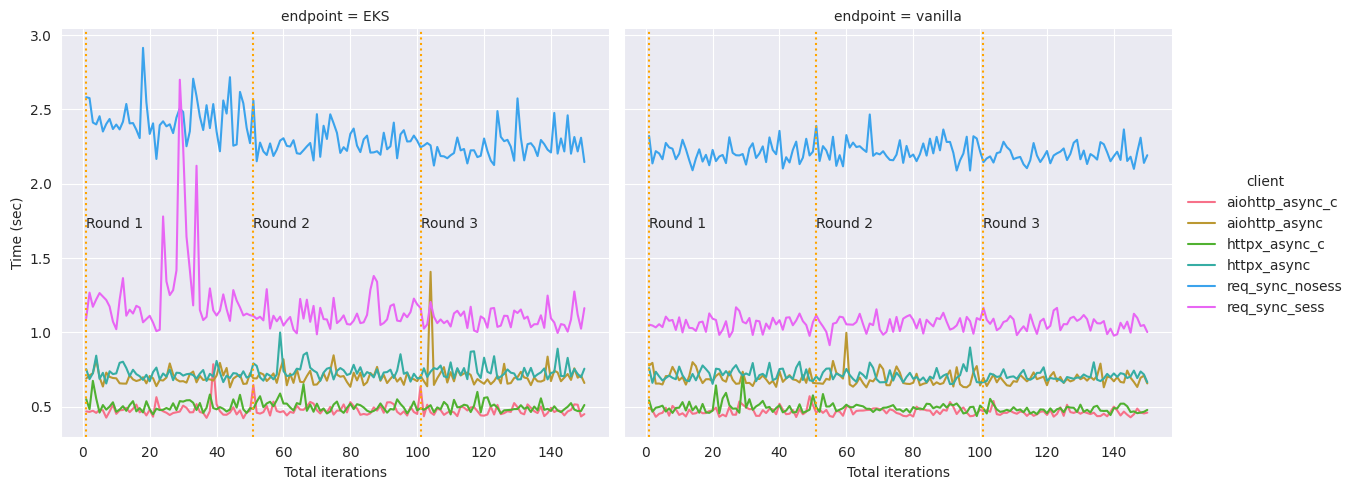

In [14]:
http_clients = cloud[cloud['client'].str.startswith(('aiohttp', 'httpx', 'req'))]
g = sns.relplot(data=http_clients, kind="line", y='time', x='total_iterations', 
                col='endpoint', 
                hue='client', 
                aspect=1.2
                )
g.set_axis_labels("Total iterations", "Time (sec)")

for ax in g.axes.ravel():
    ax.axvline(x=1, color='orange', linestyle=':')
    ax.axvline(x=51, color='orange', linestyle=':')
    ax.axvline(x=101, color='orange', linestyle=':')
    ax.text(x=1, y=1.7, s="Round 1")
    ax.text(x=51, y=1.7, s="Round 2")
    ax.text(x=101, y=1.7, s="Round 3")

Analyzing Kubernetes clients, they generally present higher response times, probably due to overhead produced by their abstraction and ease of use. In particular, according to the tests conducted, the kr8s client showed a much slower start to the round than the rest.

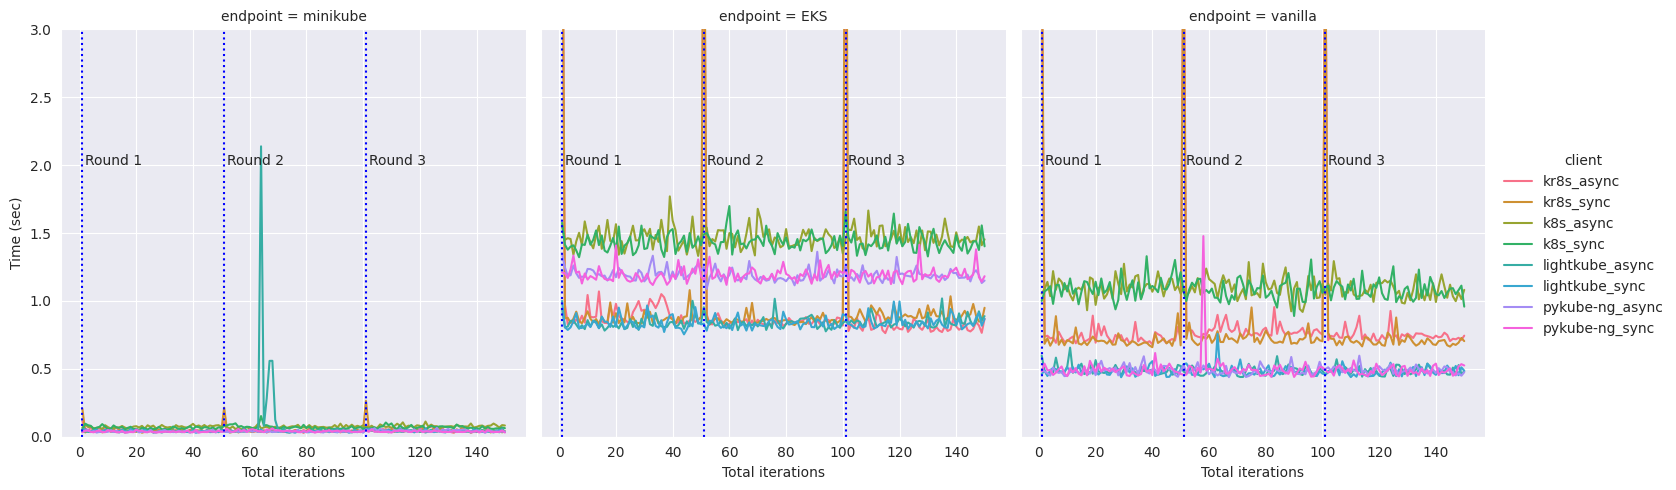

In [15]:
k8s_clients = data[data['client'].str.startswith(('kr8s', 'pykube', 'k8s', 'lightkube'))]
g = sns.relplot(data=k8s_clients, kind="line", y='time', x='total_iterations', 
                col='endpoint', 
                hue='client', 
                aspect=1
                )

for ax in g.axes.ravel():
    ax.axvline(x=1, color='blue', linestyle=':')
    ax.axvline(x=51, color='blue', linestyle=':')
    ax.axvline(x=101, color='blue', linestyle=':')
    ax.text(x=2, y=2, s="Round 1")
    ax.text(x=52, y=2, s="Round 2")
    ax.text(x=102, y=2, s="Round 3")

g.set(ylim=(0,3),
      ylabel="Time (sec)",
      xlabel='Total iterations')

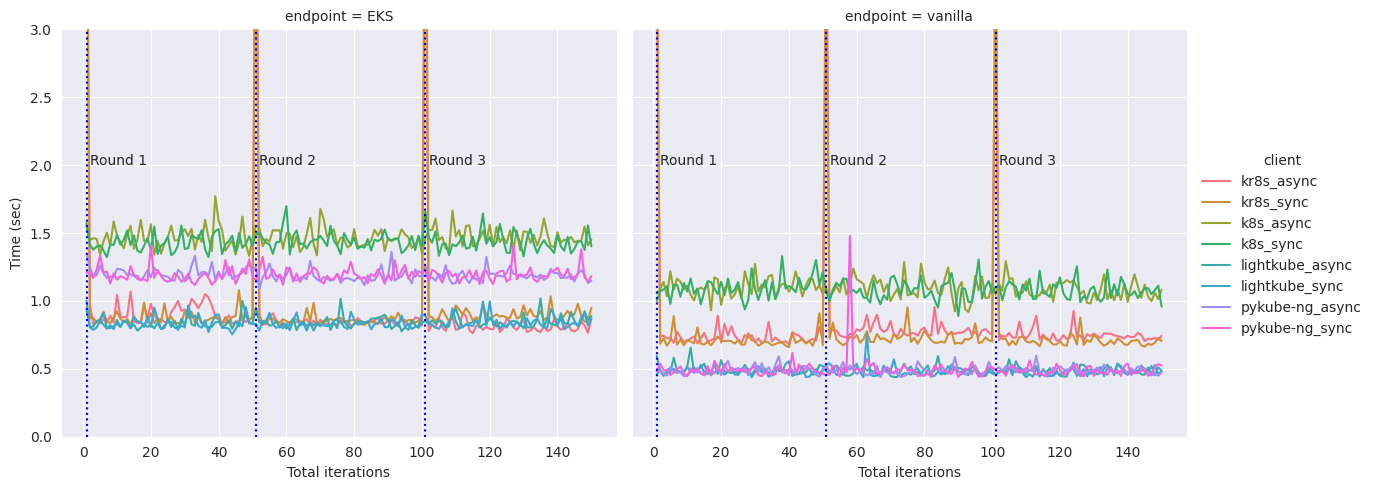

In [39]:
k8s_clients = cloud[cloud['client'].str.startswith(('kr8s', 'pykube', 'k8s', 'lightkube'))]
g = sns.relplot(data=k8s_clients, kind="line", y='time', x='total_iterations', 
                col='endpoint', 
                hue='client', 
                aspect=1.2
                )

for ax in g.axes.ravel():
    ax.axvline(x=1, color='blue', linestyle=':')
    ax.axvline(x=51, color='blue', linestyle=':')
    ax.axvline(x=101, color='blue', linestyle=':')
    ax.text(x=2, y=2, s="Round 1")
    ax.text(x=52, y=2, s="Round 2")
    ax.text(x=102, y=2, s="Round 3")

g.set(ylim=(0,3),
      ylabel="Time (sec)",
      xlabel='Total iterations')

In [32]:
best_http_library = cloud['client'] == 'aiohttp_async_c'
best_k8s_client = cloud['client'] == 'lightkube_sync'
best = cloud[best_k8s_client | best_http_library]
best.sample(20)

,client,endpoint,time,hour,iteration,round,total_iterations
3541,aiohttp_async_c,EKS,0.5310,18,42,2,92.0
3262,lightkube_sync,vanilla,0.7571,18,13,2,63.0
2828,aiohttp_async_c,vanilla,0.4486,17,29,2,79.0
1192,lightkube_sync,EKS,0.7953,0,43,1,43.0
3299,lightkube_sync,vanilla,0.4646,18,50,2,100.0
1897,lightkube_sync,vanilla,0.4981,9,48,1,48.0
4674,lightkube_sync,vanilla,0.4734,21,25,3,125.0
1416,aiohttp_async_c,vanilla,0.4569,9,17,1,17.0
1860,lightkube_sync,vanilla,0.4793,9,11,1,11.0
3531,aiohttp_async_c,EKS,0.4902,18,32,2,82.0


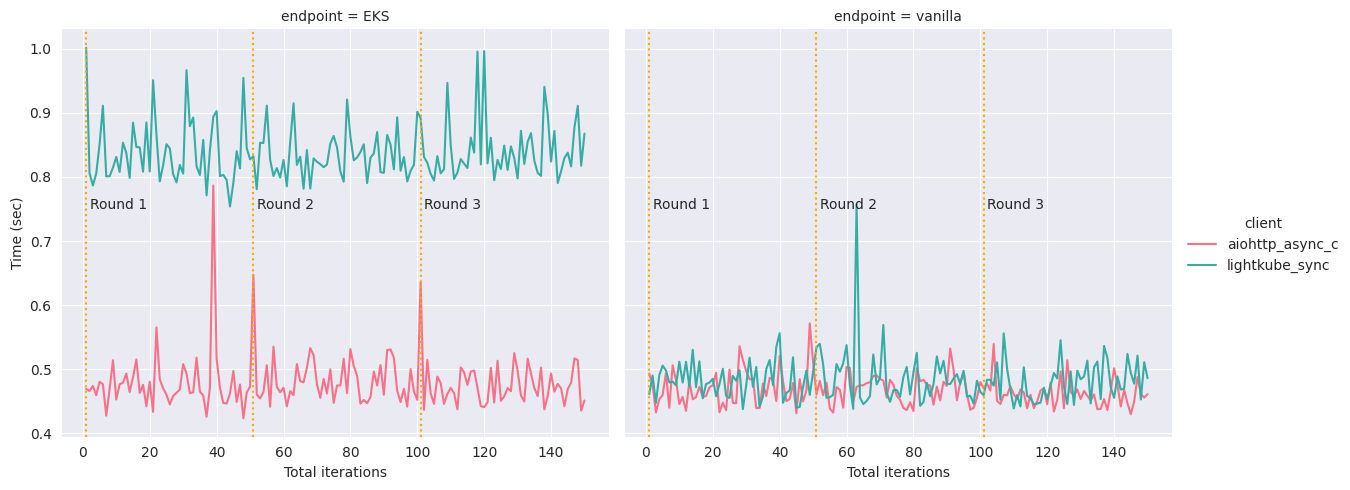

In [38]:
g = sns.relplot(data=best, kind="line", y='time', x='total_iterations', 
                col='endpoint', 
                hue='client', 
                aspect=1.2
                )
g.set_axis_labels("Total iterations", "Time (sec)")

for ax in g.axes.ravel():
    ax.axvline(x=1, color='orange', linestyle=':')
    ax.axvline(x=51, color='orange', linestyle=':')
    ax.axvline(x=101, color='orange', linestyle=':')
    ax.text(x=2, y=0.75, s="Round 1")
    ax.text(x=52, y=0.75, s="Round 2")
    ax.text(x=102, y=0.75, s="Round 3")